In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

from torch.utils.data import DataLoader
from pathlib import Path

from utils.config import LINEAR_ENCODER

from patches_dataset import PatchesDataset

import warnings
warnings.filterwarnings("ignore")

Seed set to 16


In [5]:
# Root path
root_path_coco = Path('coco_files/') # Prefix path to coco files
root_path_netcdf = Path('dataset/netcdf')  # Path to the netCDF files

# Path to coco file
coco_train = COCO(root_path_coco / 'coco_example.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
print(list(sorted(coco_train.imgs.keys())))

[1]


In [7]:
# Dataset parameters
group_freq = '1MS'
prefix = 'pre_alpha_tests'
bands = sorted(['B02', 'B03', 'B04'])
saved_medians = False # Toggle True to trade storage for loading time
window_len = 6
requires_norm = False
return_masks = False
clouds = False
cirrus = False
shadow = False
snow = False
output_size = (183, 183) # Return sub-patches of 183x183 size

In [8]:
# Create dataset instances
dataset_train = PatchesDataset(root_path_netcdf=root_path_netcdf,
                               coco=coco_train,
                               group_freq=group_freq,
                               prefix=prefix,
                               bands=bands,
                               linear_encoder=LINEAR_ENCODER,
                               saved_medians=saved_medians,
                               window_len=window_len,
                               requires_norm=requires_norm,
                               return_masks=return_masks,
                               clouds=clouds,
                               cirrus=cirrus,
                               shadow=shadow,
                               snow=snow,
                               output_size=output_size
                              )

In [9]:
batch_size = 1
num_workers = 8

# Create dataloader instances
dataloader_train = DataLoader(dataset_train,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True
                             )

In [11]:
batch = next(iter(dataloader_train))

print(type(batch))
print(f'batch contains: {list(batch.keys())}')

medians = batch['medians']
print(f'medians: {medians.shape}')

labels = batch['labels']
print(f'labels: {labels.shape}')

Seed set to 16
Seed set to 16
Seed set to 16
Seed set to 16
Seed set to 16
Seed set to 16
Seed set to 16
Seed set to 16


<class 'dict'>
batch contains: ['medians', 'labels', 'idx']
medians: torch.Size([1, 6, 3, 183, 183])
labels: torch.Size([1, 183, 183])


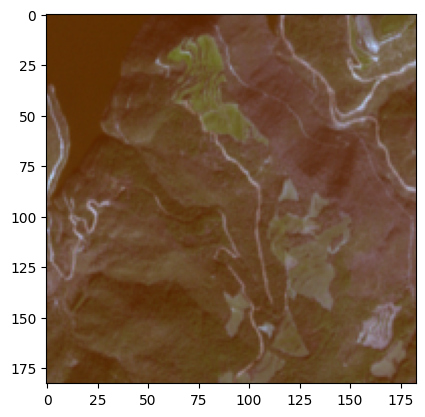

In [29]:
# Plot a subpatch
img = medians.cpu().detach().numpy()
img = img[0, 0]

img = img.transpose(1, 2, 0)

# Using current max, min for normalizing from [0, 1k] -> [0, 1]
# cause dividing by 1k, makes the image dark
img = (img - img.min()) * (1 / (img.max() - img.min()))

plt.imshow(img)
plt.show()

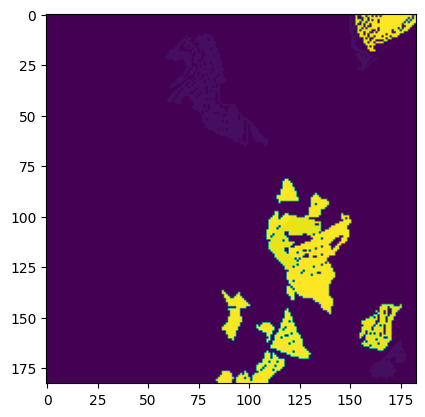

In [30]:
# And the labels
labimg = labels.cpu().detach().numpy()
labimg = labimg[0]

# Using current max, min for normalizing from [0, 1k] -> [0, 1]
# cause dividing by 1k, makes the image dark
labimg = (labimg - labimg.min()) * (1 / (labimg.max() - labimg.min()))

plt.imshow(labimg)
plt.show()

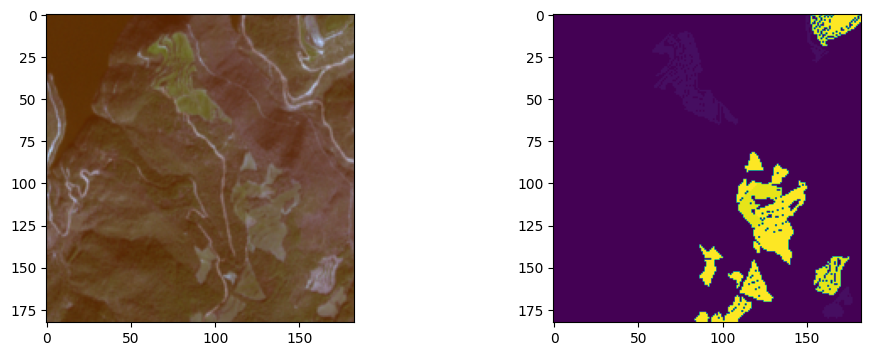

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
_ = ax[0].imshow(img)
_ = ax[1].imshow(labimg)
plt.show()

In [50]:
img2 = labels.cpu().detach().numpy()
print("Patch Shape:", img2.shape)
print("Unique Labels:", np.unique(img2))

Patch Shape: (1, 183, 183)
Unique Labels: [  0   6 162 168]


#### Decode the labels to names

In [54]:
# We have to reverse the linear encoder to look up all the numerical labels
LINEAR_DECODER = dict((v,k) for k, v in LINEAR_ENCODER.items())
codes = np.vectorize(LINEAR_DECODER.get)(np.unique(img2))
print(codes)
# The numberical labels are values and the names are keys; these must also be reversed
from utils import CROP_ENCODING
CROP_DECODING = dict((v,k) for k, v in CROP_ENCODING.items())
CROP_DECODING[0] = "UNDEFINED"
fields = np.vectorize(CROP_DECODING.get)(codes)
print(fields)

[  0 150 975 998]
['UNDEFINED' 'Barley' 'Fallow land' 'Unknown crops']


### Attempt to combine steps

In [55]:
codes = np.unique(img2)
print(codes)
labels = np.vectorize(CROP_DECODING.get)(np.vectorize(LINEAR_DECODER.get)(codes))
print(labels)

[  0   6 162 168]
['UNDEFINED' 'Barley' 'Fallow land' 'Unknown crops']


### Display raw encoder data

In [58]:
print("Crops:", CROP_ENCODING)
print("\nIndexes:", LINEAR_ENCODER)

Crops: {'Cereals': 100, 'Wheat': 110, 'Maize': 120, 'Rice': 130, 'Sorghum': 140, 'Barley': 150, 'Rye': 160, 'Oats': 170, 'Millets': 180, 'Other cereals n.e.c.': 190, 'Mixed cereals': 191, 'Other': 192, 'Vegetables and melons': 200, 'Leafy or stem vegetables': 210, 'Artichokes': 211, 'Asparagus': 212, 'Cabbages': 213, 'Cauliflowers and broccoli': 214, 'Lettuce': 215, 'Spinach': 216, 'Chicory': 217, 'Other leafy or stem vegetables n.e.c.': 219, 'Fruit bearing vegetables': 220, 'Cucumbers': 221, 'Eggplants (aubergines)': 222, 'Tomatoes': 223, 'Watermelons': 224, 'Cantaloupes and other melons': 225, 'Pumpkin squash and gourds': 226, 'Other fruit bearing vegetables n.e.c.': 227, 'Root bulb or tuberous vegetables': 230, 'Carrots': 231, 'Turnips': 232, 'Garlic': 233, 'Onions (incl. shallots)': 234, 'Leeks and other alliaceous vegetables': 235, 'Other root bulb or tuberous vegetables n.e.c.': 236, 'Mushrooms and truffles': 240, 'Vegetables n.e.c.': 250, 'Fruit and nuts': 300, 'Tropical and sub